In [1]:
%%capture
!pip install numpy pandas scikit-learn tensorflow xgboost statsmodels matplotlib

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
df = pd.read_csv("seaport_eta_dataset.csv")

# Features and target
X = df.drop("eta", axis=1)
y = df["eta"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Reshape data for LSTM (samples, timesteps, features)
X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build LSTM model
model_lstm = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")

# Train LSTM model
history_lstm = model_lstm.fit(
    X_train_lstm, y_train, epochs=150, batch_size=32,
    validation_data=(X_test_lstm, y_test), verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 2907.6313 - val_loss: 2431.8376
Epoch 2/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2336.3418 - val_loss: 1606.9384
Epoch 3/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1479.3026 - val_loss: 997.0613
Epoch 4/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 979.7929 - val_loss: 632.5162
Epoch 5/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 650.5098 - val_loss: 442.1708
Epoch 6/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 490.8351 - val_loss: 353.9411
Epoch 7/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 380.3409 - val_loss: 310.8960
Epoch 8/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 380.4771 - val_loss: 281.1078
Epoch 9/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 342.3195 - val_loss: 255.0048
Epoch 10/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 305.9877 - val_loss: 232.1105
Epoch 11/150
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 278.0805 - val_loss:

In [5]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Train XGBoost model
model_xgb = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
model_xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate performance
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost MAE: {mae_xgb}, RMSE: {rmse_xgb}")

XGBoost MAE: 1.7699815559062426, RMSE: 2.2581579465992627


In [6]:
from sklearn.linear_model import LinearRegression

# Train Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

LinearRegression()

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predictions
y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()
y_pred_xgb = model_xgb.predict(X_test)
y_pred_lr = model_lr.predict(X_test)

# Calculate metrics
metrics = {
    "LSTM": {
        "MAE": mean_absolute_error(y_test, y_pred_lstm),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_lstm))
    },
    "XGBoost": {
        "MAE": mean_absolute_error(y_test, y_pred_xgb),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_xgb))
    },
    "Linear Regression": {
        "MAE": mean_absolute_error(y_test, y_pred_lr),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_lr))
    }
}

print(metrics)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
{'LSTM': {'MAE': 1.7549144679455648, 'RMSE': 2.2766022093188334}, 'XGBoost': {'MAE': 1.7699815559062426, 'RMSE': 2.2581579465992627}, 'Linear Regression': {'MAE': 9.68143226723655, 'RMSE': 12.774067052947368}}


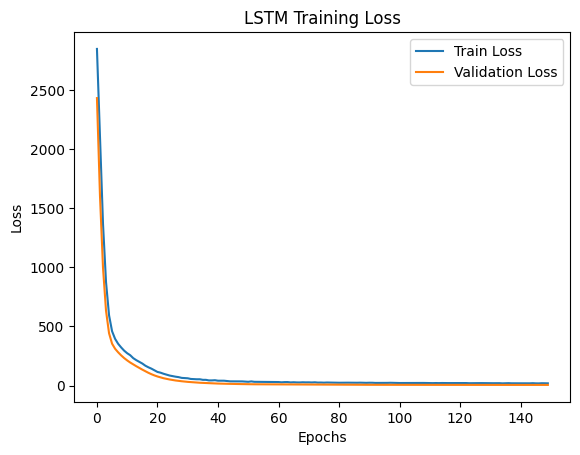

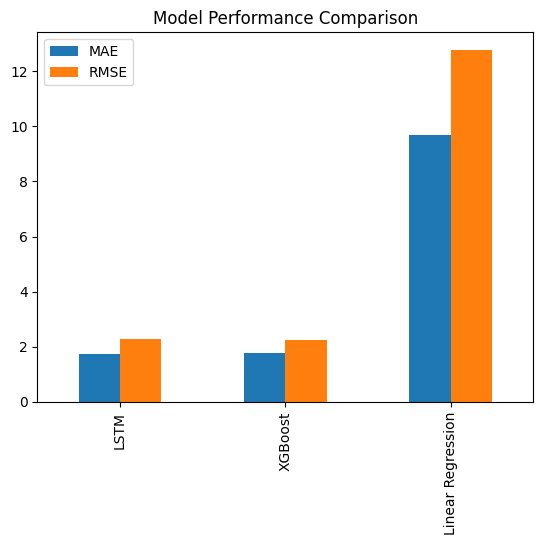

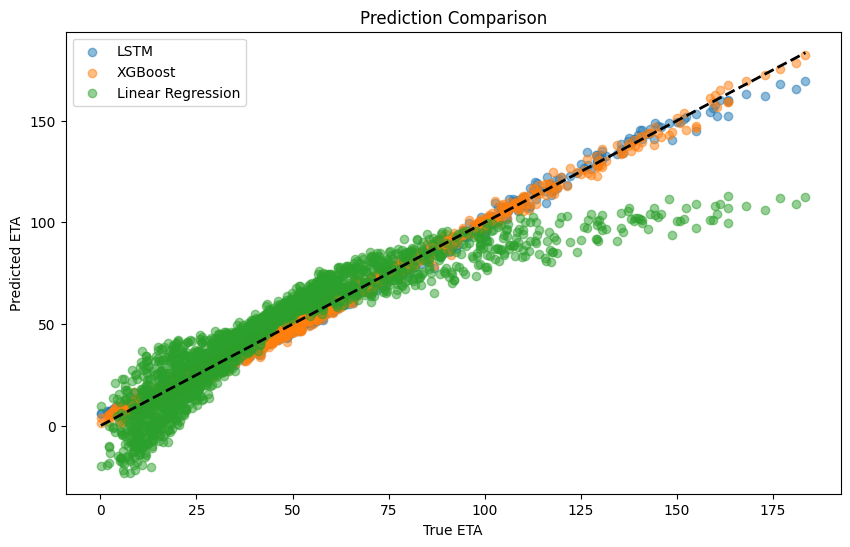

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Training plot
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Validation Loss")
plt.title("LSTM Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Performance metrics comparison
metrics_df = pd.DataFrame(metrics).T
metrics_df.plot(kind="bar", y=["MAE", "RMSE"], title="Model Performance Comparison")
plt.show()

# Prediction comparison
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lstm, label="LSTM", alpha=0.5)
plt.scatter(y_test, y_pred_xgb, label="XGBoost", alpha=0.5)
plt.scatter(y_test, y_pred_lr, label="Linear Regression", alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=2)
plt.xlabel("True ETA")
plt.ylabel("Predicted ETA")
plt.title("Prediction Comparison")
plt.legend()
plt.show()